In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import *
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from classes import (
    NewColumnTransformer,
    ColumnDropper,
    DuplicateRemover,
    ConditionalRowRemover,
    CustomImputer,
    OutlierRemover_IQR,
    CustomLabelEncoder,
    CustomPowerTransformer,
    NormalizeTransformer
)
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture

In [9]:
file_path = r"C:\Users\iza12\DEM\HotelCustomersDataset.xlsx"

raw_data = pd.read_excel(file_path, index_col="ID")
raw_data

,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
ID,,,,,,,,,,,,,,,,,,,,,
1,PRT,51.0,150,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,45,371.0,105.3,1,0,...,0,0,0,0,0,0,0,0,0,0
2,PRT,NaN,1095,0x21EDE41906B45079E75385B5AA33287CA09DE1AB86DE...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,61,280.0,53.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DEU,31.0,1095,0x31C5E4B74E23231295FDB724AD578C02C4A723F4BA2B...,0xC7CF344F5B03295037595B1337AC905CA188F1B5B3A5...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FRA,60.0,1095,0xFF534C83C0EF23D1CE516BC80A65D0197003D27937D4...,0xBD3823A9B4EC35D6CAF4B27AE423A677C0200DB61E82...,93,240.0,60.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,FRA,51.0,1095,0x9C1DEF02C9BE242842C1C1ABF2C5AA249A1EEB4763B4...,0xE175754CF77247B202DD0820F49407C762C14A603B3A...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83586,ITA,54.0,0,0x68010434A46BA6CEAFFACF00B7B7CD0E1825DC56E68F...,0x0A4038E9AE1E4E5A14832BEACEC6BCBE2219F275B65C...,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
83587,IRL,47.0,0,0x6DE7954E6AF065D29EF5C57D0DC8120FBAE6753D2CCB...,0xC0654B6A53840DD95DAE429966EC16E2A11FB186CC7B...,109,327.1,277.5,0,0,...,0,0,0,0,1,0,0,0,0,0
83588,IRL,53.0,0,0x533C977BA6D1D8DFAD8D8D4C2250236D16EFD17B9F35...,0x3DCBEB254247836015CA95F0BBF42E6AF6A158380663...,0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
final_preprocessing_pipeline = make_pipeline(
    NewColumnTransformer(columns=["LodgingRevenue", "OtherRevenue"], operation="add", new_column_name="TotalRevenue"),
    NewColumnTransformer(columns=["PersonsNights", "RoomNights"], operation="divide", new_column_name="PersonsRoomNight"),
    ColumnDropper(columns_to_drop=["PersonsNights", "RoomNights", "LodgingRevenue", "OtherRevenue", 
                                   "DaysSinceFirstStay", "DaysSinceLastStay",
                                   "BookingsCanceled", "BookingsNoShowed", 
                                   "SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", 
                                   "SRBathtub", "SRShower", "SRCrib", "SRNearElevator", "SRAwayFromElevator", 
                                   "SRNoAlcoholInMiniBar", "NameHash", "DocIDHash", 
                                   "SRKingSizeBed", "SRTwinBed", "SRQuietRoom"]),   # New columns to drop
    DuplicateRemover(),
    ConditionalRowRemover(conditions={
    "LodgingRevenue": 0,    # Assuming total amount spent on lodging expenses by the customer cannot be 0
    "AverageLeadTime": -1   # Assuming, the average number of days elapsed between the customer's booking date and arrival date cannot be negative
                            # The only negative value appearing in this column is -1
    }),
    CustomImputer(strategy="mean", columns=["Age"]),
    OutlierRemover_IQR(),
    CustomLabelEncoder(columns=["Nationality", "DistributionChannel", "MarketSegment"]),
    NormalizeTransformer(norm='l2'),
    CustomPowerTransformer(columns=["Nationality", "Age", "DaysSinceCreation", "BookingsCheckedIn",
                                    "AverageLeadTime", "PersonsRoomNight", "TotalRevenue",
                                    "MarketSegment", "DistributionChannel"], standardize=True)
)

In [11]:
df_done = final_preprocessing_pipeline.fit_transform(raw_data)
df_done

,Nationality,Age,DaysSinceCreation,AverageLeadTime,BookingsCheckedIn,DistributionChannel,MarketSegment,TotalRevenue,PersonsRoomNight
0,0.242000,-1.026607,1.098050,-0.380854,-1.424965,-0.628480,-0.562721,-1.046229,-0.928053
1,-0.895943,-0.457182,1.160096,0.023587,-1.395632,-0.613000,-0.539656,-1.142376,-0.906943
2,-0.372088,-0.648678,1.226269,-0.404759,-1.365063,-0.596801,-0.912662,-1.282708,-0.884897
3,-1.009025,-1.760942,0.608823,-0.765386,-1.682359,-0.761714,-1.145564,-0.265876,-1.111520
4,-0.529811,-1.947610,1.234320,0.069863,-1.361392,-0.594851,-0.512710,-1.317700,-0.882247
...,...,...,...,...,...,...,...,...,...
53209,0.485914,1.568604,-1.825687,-0.263162,1.670161,1.737832,1.753439,1.568743,1.727605
53210,1.686063,2.223972,-1.825687,1.961614,2.114751,2.660245,2.385791,0.796589,2.354577
53211,0.915172,1.100702,-1.825687,1.347244,1.043427,1.034838,1.088194,1.447341,1.071843
53212,0.360198,0.313542,-1.825687,0.930718,0.344400,0.458332,0.448206,1.550756,0.443778


In [12]:
# PCA
pca = PCA(n_components = 3)
X_principal = pca.fit_transform(df_done)
X_principal = pd.DataFrame(X_principal, columns=['P1', 'P2', 'P3']) 
X_principal

,P1,P2,P3
0,-2.376034,0.755368,-0.033196
1,-2.379256,0.525143,-0.892002
2,-2.580734,0.827557,-0.330784
3,-3.157934,-0.620437,-0.016970
4,-2.839845,0.522077,-0.927866
...,...,...,...
53209,4.278635,-0.582903,0.697403
53210,6.070261,0.217053,-0.778992
53211,3.439081,-1.213019,-0.041484
53212,1.954327,-1.851273,0.168958


Silhouette Score for Birch Clustering: 0.20


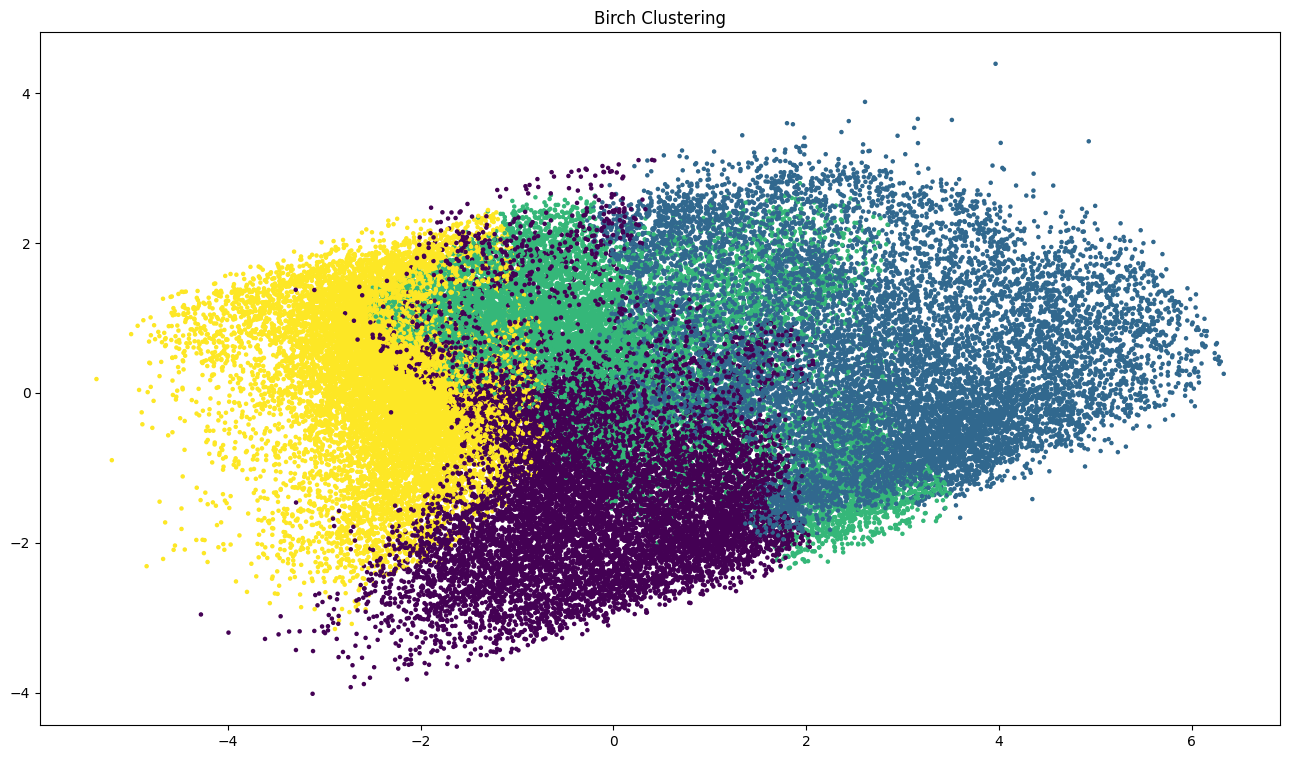

In [13]:
# Birch Clustering

birch = Birch(n_clusters=4)
birch.fit(X_principal)
labels_birch = birch.predict(X_principal)

# Silence the CPU physical cores warning
os.environ["LOKY_MAX_CPU_COUNT"] = "4" # The number of cores to use

# Evaluate clustering with silhouette score
birch_silhouette = silhouette_score(X_principal, labels_birch)
print(f'Silhouette Score for Birch Clustering: {birch_silhouette:.2f}')

# Plotting Birch Clustering results
plt.figure(figsize=(16, 9))
plt.scatter(X_principal.iloc[:, 0], X_principal.iloc[:, 1], c=labels_birch, cmap='viridis', s=5)
plt.title('Birch Clustering')
plt.show()

Silhouette Score for GMM Clustering: 0.22


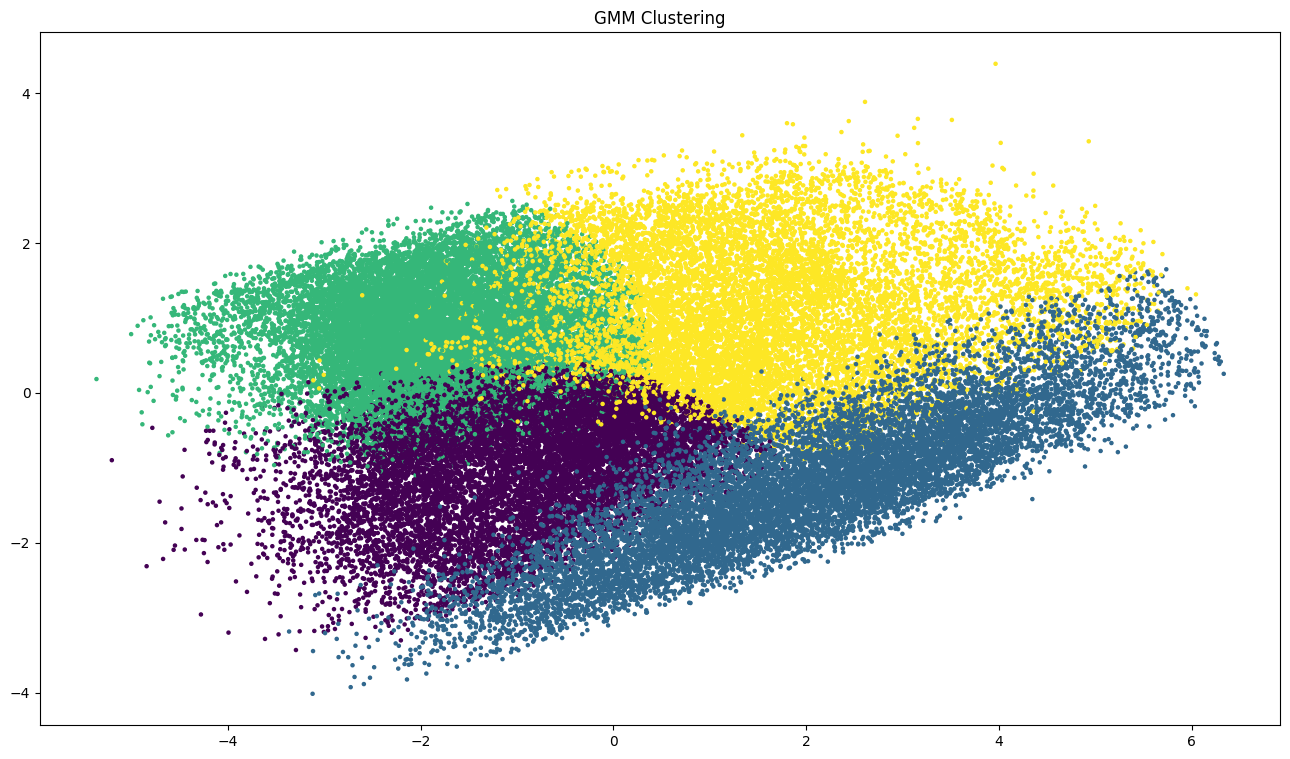

In [14]:
# GMM Clustering

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_principal)
labels_gmm = gmm.predict(X_principal)

# Evaluate clustering with silhouette score
gmm_silhouette = silhouette_score(X_principal, labels_gmm)
print(f'Silhouette Score for GMM Clustering: {gmm_silhouette:.2f}')

# Plotting GMM Clustering results
plt.figure(figsize=(16, 9))
plt.scatter(X_principal.iloc[:, 0], X_principal.iloc[:, 1], c=labels_gmm, cmap='viridis', s=5)
plt.title('GMM Clustering')
plt.show()